In [20]:
%matplotlib notebook
import numpy as np
import pickle
import pylab
import catdata as cd
import catbeam as cb
import gencat as gc
import healpy
import glob
from collections import OrderedDict
import time
import aipy
import linsolve
import coord_utils as ct

In [21]:
%load_ext autoreload
%autoreaload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


UsageError: Line magic function `%autoreaload` not found.


In [3]:
beamfile1 = '../../beams/HERA_4.9m_E-pattern_151MHz.txt'
beamfile2 = '../../beams/HERA_4.9m_E-pattern_152MHz.txt'
bm = cb.catBeamCst([beamfile1, beamfile2], [151e6, 152e6], 151.5e6, 'xx')
beam = bm.generate_beam()

<IPython.core.display.Javascript object>


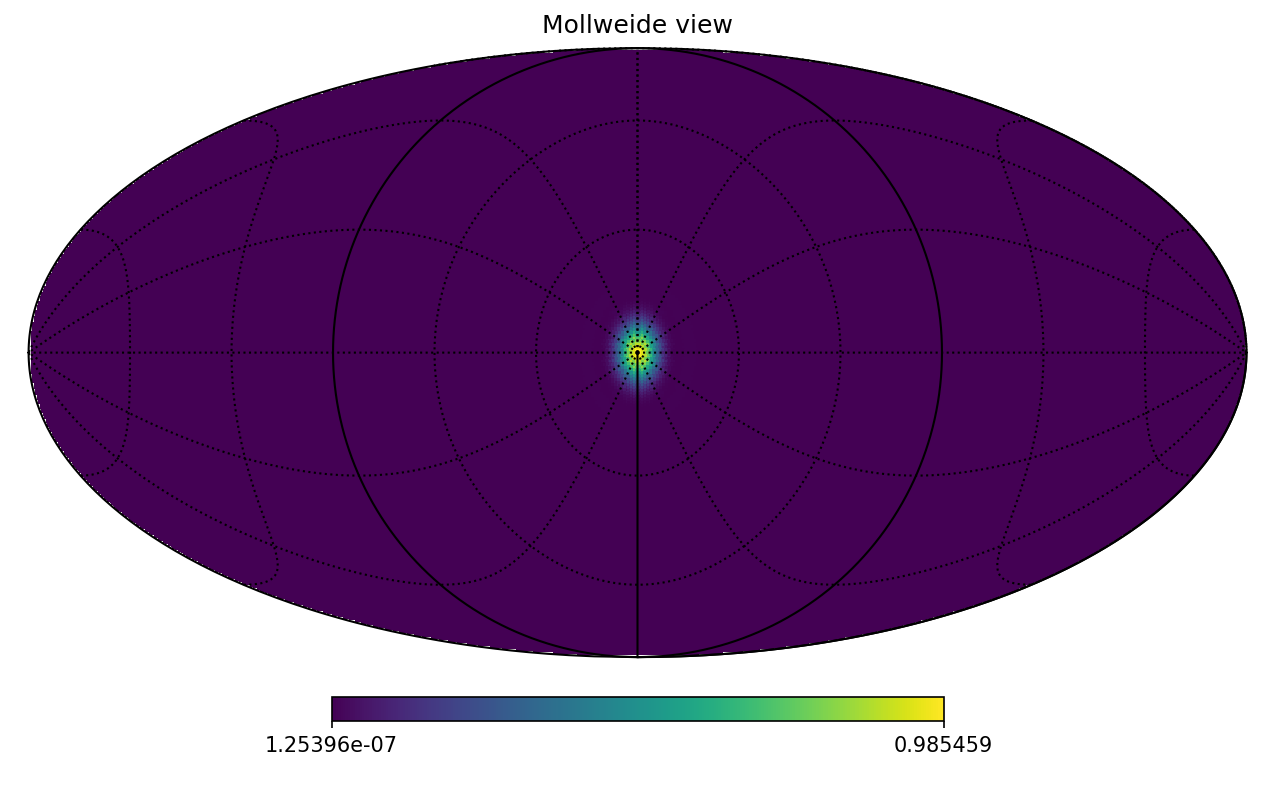

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [8]:
healpy.mollview(beam['data']['xx'], rot=[0, 90])
healpy.graticule()

<IPython.core.display.Javascript object>


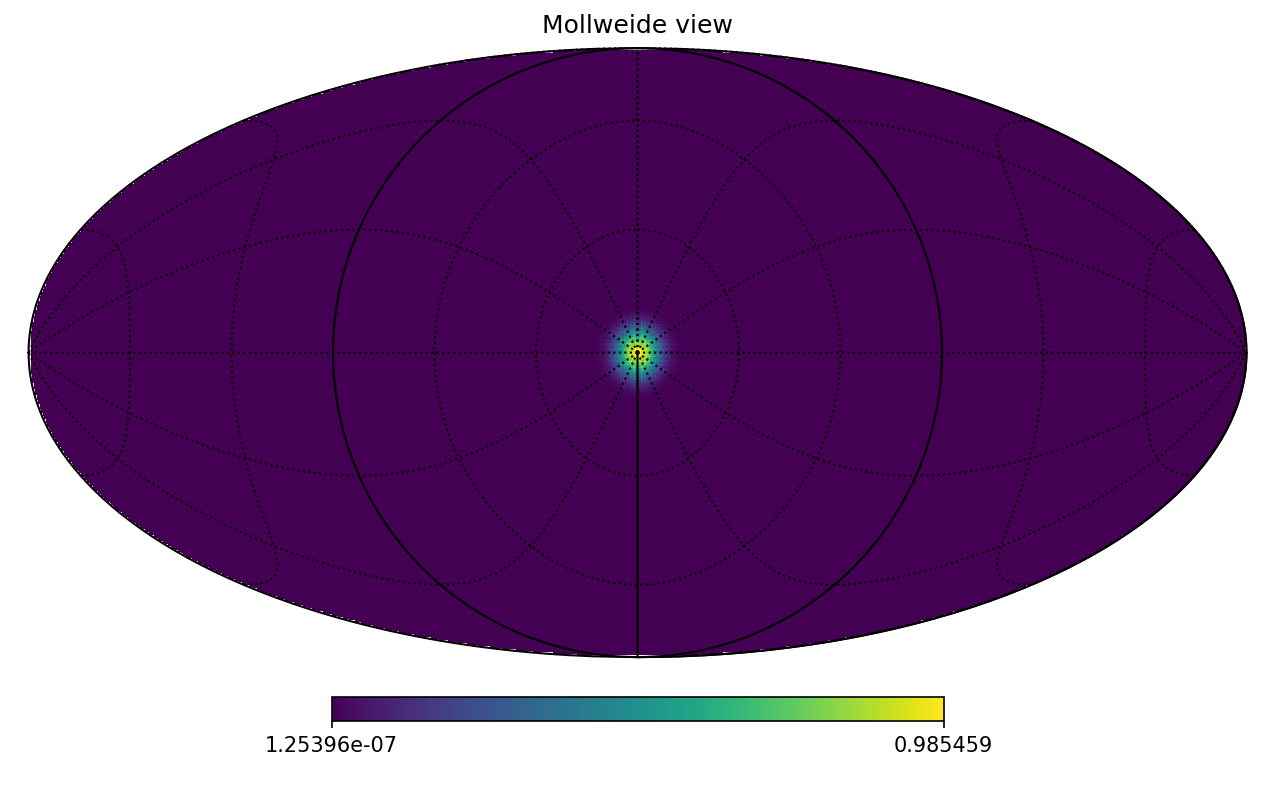

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


In [4]:
healpy.mollview(beam['data']['yy'], rot=[0, 90])
healpy.graticule()

In [5]:
srcs = pickle.load(open('../../scripts/herasrc.pkl'))
ras = srcs['ra']
decs = srcs['dec']

In [6]:
fitsfilesxx = glob.glob('../../smooth/2458115.*.xx.fits')
fitsfilesxx = sorted(fitsfilesxx)

In [7]:
fitsfilesyy = glob.glob('../../smooth/2458115.*.yy.fits')
fitsfilesyy = sorted(fitsfilesyy)

In [8]:
fitsfilesyy.remove('../../smooth/2458115.50580.yy.fits')
fitsfilesyy.remove('../../smooth/2458115.51326.yy.fits')
fitsfilesyy.remove('../../smooth/2458115.52071.yy.fits')
fitsfilesyy.remove('../../smooth/2458115.52817.yy.fits')
fitsfilesyy.remove('../../smooth/2458115.53563.yy.fits')
fitsfilesyy.remove('../../smooth/2458115.54308.yy.fits')
fitsfilesyy.remove('../../smooth/2458115.55054.yy.fits')
fitsfilesyy.remove('../../smooth/2458115.55800.yy.fits')
fitsfilesyy.remove('../../smooth/2458115.56545.yy.fits')
fitsfilesyy.remove('../../smooth/2458115.57291.yy.fits')
fitsfilesyy.remove('../../smooth/2458115.58037.yy.fits')
fitsfilesyy.remove('../../smooth/2458115.58782.yy.fits')
fitsfilesyy.remove('../../smooth/2458115.59528.yy.fits')

In [9]:
len(fitsfilesyy)

42

In [10]:
# loading hera source catalogue
pkl_file = pickle.load(open('../../scripts/srcdict_xx.pkl'))
ras = pkl_file['ra']
decs = pkl_file['dec']
alts = pkl_file['alt']
azs = pkl_file['az']
has = pkl_file['ha']
peaks = pkl_file['peak']
corrfluxs = pkl_file['corrflux']
_sh = alts.shape
print _sh

(120, 42)


In [11]:
inds = np.where((decs>-31) & (decs <-29.5))
ras1 = ras[inds]
decs1 = decs[inds]
alts1 = alts[inds]
azs1 = azs[inds]
has1 = has[inds]
peaks1 = peaks[inds]
corrfluxs1 = corrfluxs[inds]
_sh = peaks1.shape
print _sh

(20, 42)


In [29]:
gcat = gc.genCatalog(fitsfilesxx, fitsfilesyy, ras1, decs1, beam=beam)

In [30]:
cat = gcat.gen_catologue()

42 42 42


In [31]:
cat.write_hdf5('srcd.h5', clobber=True)

Overwriting existing file


In [32]:
catd = cd.catData()
catd.read_hdf5('srcd.h5')

In [33]:
print catd.pcorr_array.shape
print catd.pcorr_array[1, :]

(2, 20)
[10.98143153 21.93487467  2.14575321  4.13390101  0.          0.13318435
  0.16473225  0.27796753  0.39886429  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ]


In [45]:
import beamsolving as bs
%autoreload
bsol = bs.BeamSolving(catd)

In [49]:
bsol.construct_linear_sys(flux_type='peak', pol='xx')
sol = bsol.solve(solver='Linear')

Solving 0/1
Time Elapsed: 0.10 seconds


In [50]:
obs_beam = bsol.eval_sol(sol)
#obs_beam = bsol.remove_degeneracies(sol, threshold=0.003)

<IPython.core.display.Javascript object>


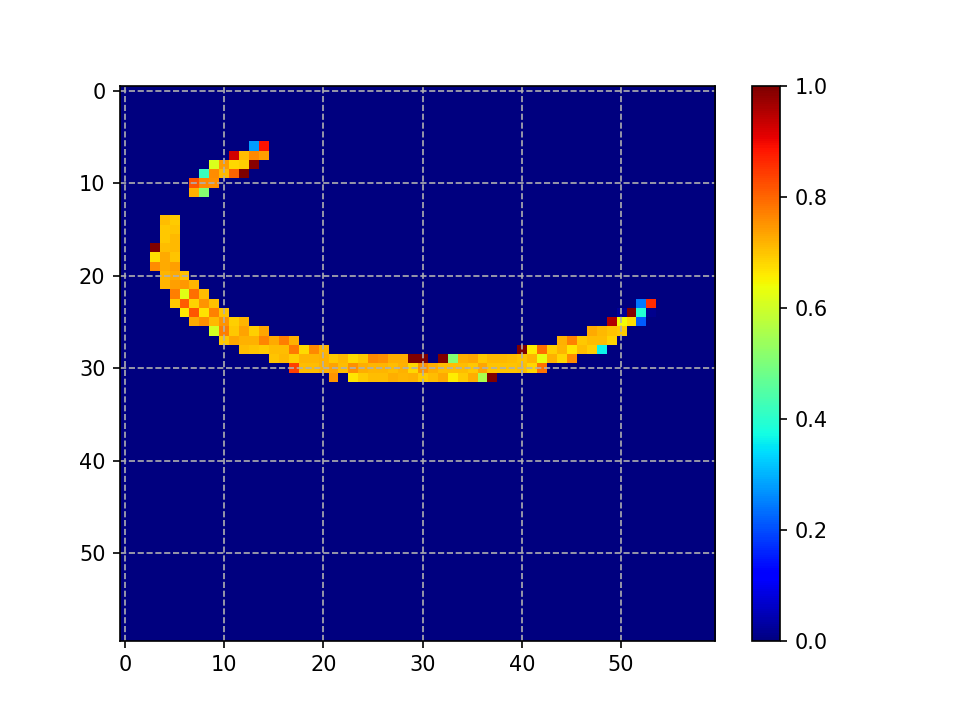

In [51]:
pylab.subplot(111)
pylab.imshow(obs_beam.reshape(60,60).T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.grid(ls='dashed')
pylab.colorbar()

In [135]:
bm_pix = 60
interp2d = np.zeros((bm_pix**2))
for key in sol.keys():
    px = int(key.strip('b'))
    interp2d[px] = sol.get(key)

<IPython.core.display.Javascript object>


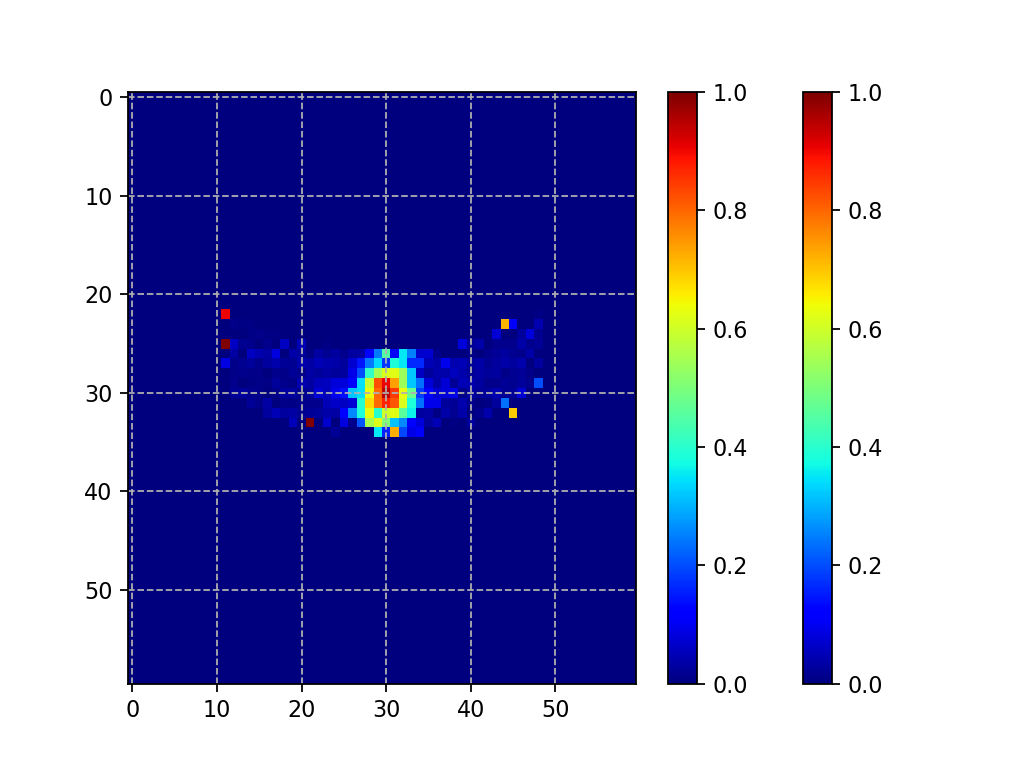

In [136]:
interp2d.shape = (bm_pix, bm_pix)
pylab.subplot(111)
pylab.imshow(interp2d.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.grid(ls='dashed')
pylab.colorbar()

In [124]:
obs_beam = bsol.eval_sol(sol)

IndexError: index 667 is out of bounds for axis 0 with size 60

In [81]:
def mk_key(px, i, t):
    return 'w%d_s%d_t%d' % (px, i, t)

def unravel_pix(n, i,j):
    return (i*n) + j
    

bm_pix = 60
_sh = peaks1.shape
print _sh
consts = OrderedDict()
eqs = OrderedDict()
interp2d = np.zeros((bm_pix**2))

time0 = time.time()
for i in range(0, 1):
    tx, ty, tz = aipy.coord.azalt2top([np.deg2rad(azs1[i,:]), np.deg2rad(alts1[i, :])])
    tx_px = tx * 0.5*bm_pix + 0.5*bm_pix
    tx_px0 = np.floor(tx_px).astype(np.int)
    tx_px1 = np.clip(tx_px0+1,0,bm_pix-1)
    fx = tx_px - tx_px0
    ty_px = ty * 0.5*bm_pix + 0.5*bm_pix
    ty_px0 = np.floor(ty_px).astype(np.int)
    ty_px1 = np.clip(ty_px0+1,0,bm_pix-1)
    fy = ty_px - ty_px0
    x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
    x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
    x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
    x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)

    w0 = ((1 - fx) * (1 - fy))
    w1 = (fx * (1 - fy))
    w2 = ((1 - fx) * fy)
    w3 = (fx * fy)
    
    ps = [x0y0, x0y1, x1y0, x1y1]
    ws = [w0, w1, w2, w3]
    for j in xrange(_sh[1]): 
        weights = w0[j] + w1[j] + w2[j] + w3[j]
        flux = 0 if np.isnan(peaks1[i,j]) else peaks1[i,j]
        print flux
        if alts1[i,j]>=0:
            c = {mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j): 1 * ws[p][j] for p in xrange(len(ps))}
            print c
            eq = ' + '.join([mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j) + 
             '*b%d'%(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j])) for p in xrange(len(ps))])
            eqs[eq] =  flux / corrfluxs1[i]
            consts.update(c)

eqs_beam = {k:v for k,v in eqs.items()}
ls = linsolve.LinearSolver(eqs_beam, **consts)
sol = ls.solve(verbose=True)

for key in sol.keys():
    px = int(key.strip('b'))
    interp2d[px] = sol.get(key)

print 'Time Elapsed: {} s'.format(time.time() - time0)    

(20, 42)
9.16360855102539
{'w2010_s0_t0': 0.4956943844218195, 'w2009_s0_t0': 0.3980216283956444, 'w1950_s0_t0': 0.058949794839475746, 'w1949_s0_t0': 0.04733419234306032}
14.102113723754883
{'w1889_s0_t1': 0.038782251177900066, 'w1890_s0_t1': 0.020646942825197693, 'w1950_s0_t1': 0.32677393628215595, 'w1949_s0_t1': 0.6137968697147463}
15.905085563659668
{'w1830_s0_t2': 0.005709072567502462, 'w1829_s0_t2': 0.03589482079171375, 'w1890_s0_t2': 0.13151540587756044, 'w1889_s0_t2': 0.8268807007632233}
13.446024894714355
{'w1769_s0_t3': 0.06787979714792955, 'w1770_s0_t3': 0.8793122449180916, 'w1709_s0_t3': 0.0037844421333356475, 'w1710_s0_t3': 0.04902351580064321}
9.088918685913086
{'w1649_s0_t4': 0.02603608839639579, 'w1710_s0_t4': 0.653181529863787, 'w1650_s0_t4': 0.06701537998592824, 'w1709_s0_t4': 0.25376700175388905}
4.587568283081055
{'w1649_s0_t5': 0.4045550725956187, 'w1590_s0_t5': 0.08389799591689423, 'w1650_s0_t5': 0.433195859904627, 'w1589_s0_t5': 0.07835107158286009}
1.5877150297164

<IPython.core.display.Javascript object>


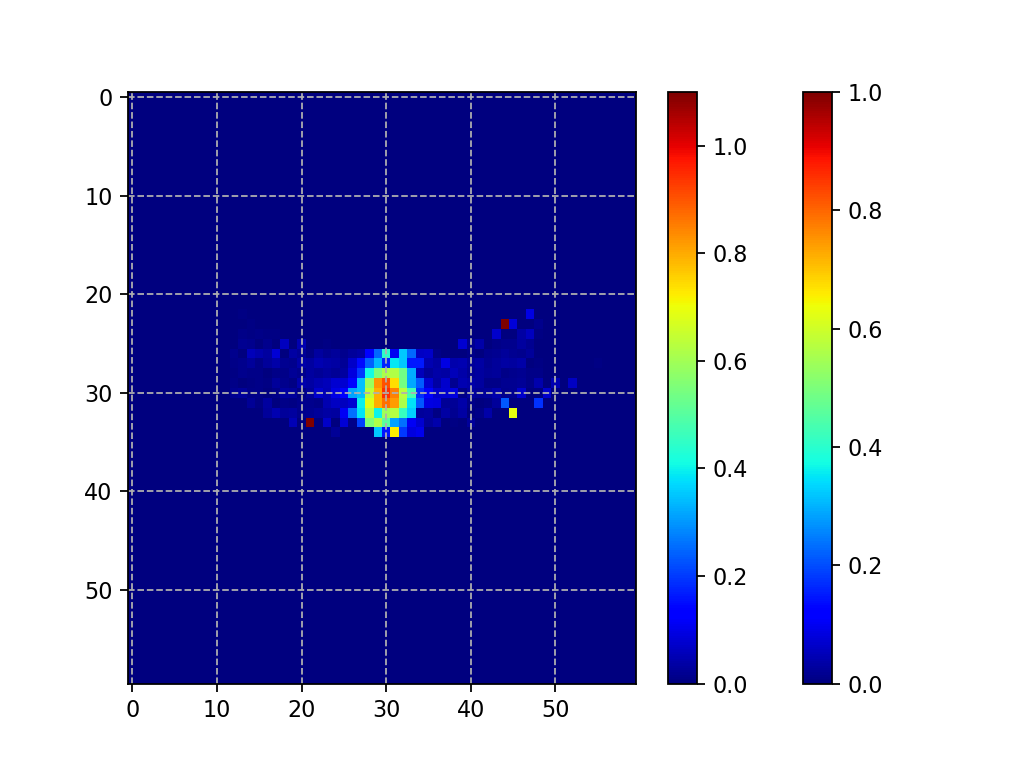

In [115]:
interp2d.shape = (bm_pix, bm_pix)
pylab.subplot(111)
pylab.imshow(interp2d.T, aspect='auto', cmap='jet', vmin=0, vmax=1.0)
pylab.grid(ls='dashed')
pylab.colorbar()

In [113]:
def mk_key(px, i, t):
    return 'w%d_s%d_t%d' % (px, i, t)

def unravel_pix(n, i,j):
    return (i*n) + j
    

bm_pix = 60
_sh = catd.pflux_array.shape
print _sh
consts = OrderedDict()
eqs = OrderedDict()
interp2d = np.zeros((bm_pix**2))
print _sh
time0 = time.time()
for i in range(_sh[0]):
    tx, ty, tz = aipy.coord.azalt2top([np.deg2rad(catd.azalt_array[0, i,:]), np.deg2rad(catd.azalt_array[1, i, :])])
    tx_px = tx * 0.5*bm_pix + 0.5*bm_pix
    tx_px0 = np.floor(tx_px).astype(np.int)
    tx_px1 = np.clip(tx_px0+1,0,bm_pix-1)
    fx = tx_px - tx_px0
    ty_px = ty * 0.5*bm_pix + 0.5*bm_pix
    ty_px0 = np.floor(ty_px).astype(np.int)
    ty_px1 = np.clip(ty_px0+1,0,bm_pix-1)
    fy = ty_px - ty_px0
    x0y0 = np.array([tx_px0, ty_px0], dtype=np.int)
    x0y1 = np.array([tx_px0, ty_px1], dtype=np.int)
    x1y0 = np.array([tx_px1, ty_px0], dtype=np.int)
    x1y1 = np.array([tx_px1, ty_px1], dtype=np.int)

    w0 = ((1 - fx) * (1 - fy))
    w1 = (fx * (1 - fy))
    w2 = ((1 - fx) * fy)
    w3 = (fx * fy)
    
    ps = [x0y0, x0y1, x1y0, x1y1]
    ws = [w0, w1, w2, w3]
    for j in xrange(_sh[1]): 
        weights = w0[j] + w1[j] + w2[j] + w3[j]
        flux = 0 if np.isnan(catd.pflux_array[i,j]) else catd.pflux_array[i,j]
        #if catd.azalt_array[1, i,j]>=0:
        c = {mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j): 1 * ws[p][j] for p in xrange(len(ps))}
        print c
        eq = ' + '.join([mk_key(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j]), i, j) + 
             '*b%d'%(unravel_pix(bm_pix, ps[p][0,j], ps[p][1,j])) for p in xrange(len(ps))])
        eqs[eq] =  flux / catd.pcorr_array[i]
        consts.update(c)

eqs_beam = {k:v for k,v in eqs.items()}
ls = linsolve.LinearSolver(eqs_beam, **consts)
sol = ls.solve(verbose=True)

for key in sol.keys():
    px = int(key.strip('b'))
    interp2d[px] = sol.get(key)

print 'Time Elapsed: {} s'.format(time.time() - time0)    

(120, 42)
(120, 42)
{'w2010_s0_t0': 0.4956943844218195, 'w2009_s0_t0': 0.3980216283956444, 'w1950_s0_t0': 0.058949794839475746, 'w1949_s0_t0': 0.04733419234306032}
{'w1889_s0_t1': 0.038782251177900066, 'w1890_s0_t1': 0.020646942825197693, 'w1950_s0_t1': 0.32677393628215595, 'w1949_s0_t1': 0.6137968697147463}
{'w1830_s0_t2': 0.005709072567502462, 'w1829_s0_t2': 0.03589482079171375, 'w1890_s0_t2': 0.13151540587756044, 'w1889_s0_t2': 0.8268807007632233}
{'w1769_s0_t3': 0.06787979714792955, 'w1770_s0_t3': 0.8793122449180916, 'w1709_s0_t3': 0.0037844421333356475, 'w1710_s0_t3': 0.04902351580064321}
{'w1649_s0_t4': 0.02603608839639579, 'w1710_s0_t4': 0.653181529863787, 'w1650_s0_t4': 0.06701537998592824, 'w1709_s0_t4': 0.25376700175388905}
{'w1649_s0_t5': 0.4045550725956187, 'w1590_s0_t5': 0.08389799591689423, 'w1650_s0_t5': 0.433195859904627, 'w1589_s0_t5': 0.07835107158286009}
{'w1530_s0_t6': 0.08408396849349682, 'w1589_s0_t6': 0.5007073285765264, 'w1590_s0_t6': 0.2391971909497011, 'w1529_

{'w3027_s21_t0': 0.1627404894482579, 'w3026_s21_t0': 0.6356881051913165, 'w2967_s21_t0': 0.041085488905788906, 'w2966_s21_t0': 0.1604859164546367}
{'w2907_s21_t1': 0.49700243687031825, 'w2908_s21_t1': 0.2537760570832855, 'w2967_s21_t1': 0.16498034616479593, 'w2968_s21_t1': 0.08424115988160033}
{'w2848_s21_t2': 0.1386924223667798, 'w2908_s21_t2': 0.293013965386131, 'w2907_s21_t2': 0.38572040987133893, 'w2847_s21_t2': 0.18257320237575025}
{'w2848_s21_t3': 0.043754517129176364, 'w2788_s21_t3': 0.46806008693900153, 'w2789_s21_t3': 0.4464509161050853, 'w2849_s21_t3': 0.0417344798267368}
{'w2729_s21_t4': 0.26887746919645955, 'w2728_s21_t4': 0.261445224125987, 'w2789_s21_t4': 0.23812981633370503, 'w2788_s21_t4': 0.23154749034384844}
{'w2729_s21_t5': 0.4079571232859382, 'w2668_s21_t5': 0.08648644391289177, 'w2669_s21_t5': 0.08362128977702928, 'w2728_s21_t5': 0.42193514302414076}
{'w2670_s21_t6': 0.07347627496397326, 'w2610_s21_t6': 0.37209129478537717, 'w2609_s21_t6': 0.46300380649116635, 'w26

{'w1288_s38_t32': 0.15309517507176873, 'w1289_s38_t32': 0.019438899282939178, 'w1228_s38_t32': 0.7342378091190799, 'w1229_s38_t32': 0.09322811652621221}
{'w1167_s38_t33': 0.07591793639273696, 'w1227_s38_t33': 0.8978969942494157, 'w1228_s38_t33': 0.02414369951703214, 'w1168_s38_t33': 0.0020413698408152264}
{'w1107_s38_t34': 0.02328120830190713, 'w1048_s38_t34': 0.3414830010164253, 'w1047_s38_t34': 0.01277204812864511, 'w1108_s38_t34': 0.6224637425530224}
{'w987_s38_t35': 0.04609588872547832, 'w1048_s38_t35': 0.3204289832599372, 'w1047_s38_t35': 0.024244443239460622, 'w988_s38_t35': 0.6092306847751239}
{'w440_s38_t36': 0.5976328577627198, 'w441_s38_t36': 0.34895644222203853, 'w381_s38_t36': 0.019689645608932445, 'w380_s38_t36': 0.033721054406309285}
{'w320_s38_t37': 0.023838982421178406, 'w321_s38_t37': 0.6019737752034653, 'w380_s38_t37': 0.01425385306473029, 'w381_s38_t37': 0.35993338931062596}
{'w379_s38_t38': 0.3105073449569742, 'w380_s38_t38': 0.4821376393240977, 'w320_s38_t38': 0.12

{'w3381_s58_t0': 0.08050246689488065, 'w3320_s58_t0': 0.3912614507108532, 'w3321_s58_t0': 0.4597217929574637, 'w3380_s58_t0': 0.06851428943680245}
{'w3320_s58_t1': 0.1799486940894964, 'w3381_s58_t1': 0.19241193604299398, 'w3321_s58_t1': 0.06111725512004553, 'w3380_s58_t1': 0.5665221147474641}
{'w3321_s58_t2': 0.03213446896467477, 'w3262_s58_t2': 0.5818932272070225, 'w3261_s58_t2': 0.0568067666159595, 'w3322_s58_t2': 0.3291655372123432}
{'w3321_s58_t3': 0.46350856555127556, 'w3261_s58_t3': 0.022355525833415643, 'w3262_s58_t3': 0.02365636561899316, 'w3322_s58_t3': 0.49047954299631563}
{'w3323_s58_t4': 0.03361967363846374, 'w3322_s58_t4': 0.5036646418788904, 'w3263_s58_t4': 0.028953665406602495, 'w3262_s58_t4': 0.4337620190760434}
{'w3204_s58_t5': 0.4970036838439401, 'w3263_s58_t5': 0.048235386680290614, 'w3264_s58_t5': 0.06086106384815335, 'w3203_s58_t5': 0.3938998656276159}
{'w3264_s58_t6': 0.0012712240888990305, 'w3263_s58_t6': 0.6661541078539313, 'w3204_s58_t6': 0.0006334445355275891,

{'w1952_s75_t34': 0.22199225454015045, 'w1953_s75_t34': 0.02246678392487359, 'w1892_s75_t34': 0.6861036617902738, 'w1893_s75_t34': 0.0694372997447021}
{'w1772_s75_t35': 0.1255498780927794, 'w1773_s75_t35': 0.618918093134586, 'w1833_s75_t35': 0.21243814656261428, 'w1832_s75_t35': 0.04309388221002031}
{'w870_s75_t36': 0.15185548195712695, 'w810_s75_t36': 0.29431097913511284, 'w809_s75_t36': 0.36533290896580706, 'w869_s75_t36': 0.18850062994195316}
{'w808_s75_t37': 0.49300926795924166, 'w809_s75_t37': 0.4380770492469988, 'w749_s75_t37': 0.03242395710595188, 'w748_s75_t37': 0.03648972568780765}
{'w748_s75_t38': 0.23269191919575868, 'w749_s75_t38': 0.26616583410518746, 'w689_s75_t38': 0.26738472683922165, 'w688_s75_t38': 0.2337575198598322}
{'w688_s75_t39': 0.01635015632521243, 'w689_s75_t39': 0.028886238901752556, 'w628_s75_t39': 0.3450879344682436, 'w629_s75_t39': 0.6096756703047914}
{'w568_s75_t40': 0.337584640308621, 'w567_s75_t40': 0.09240097109463973, 'w627_s75_t40': 0.122492198918860

{'w2607_s88_t31': 0.3854859420184878, 'w2547_s88_t31': 0.1002997576076043, 'w2548_s88_t31': 0.10616938647136868, 'w2608_s88_t31': 0.4080449139025392}
{'w2488_s88_t32': 0.4985354646221697, 'w2489_s88_t32': 0.4204731507344651, 'w2549_s88_t32': 0.037055912332364056, 'w2548_s88_t32': 0.04393547231100114}
{'w2489_s88_t33': 0.12838192045378596, 'w2488_s88_t33': 0.21475860172156766, 'w2429_s88_t33': 0.24575611384161997, 'w2428_s88_t33': 0.4111033639830264}
{'w2428_s88_t34': 0.4239219278826354, 'w2429_s88_t34': 0.15507405681718045, 'w2369_s88_t34': 0.11275864136220258, 'w2368_s88_t34': 0.30824537393798157}
{'w2368_s88_t35': 0.6754529483985874, 'w2369_s88_t35': 0.11232135258918666, 'w2308_s88_t35': 0.18196642609947736, 'w2309_s88_t35': 0.03025927291274863}
{'w1348_s88_t36': 0.25120063516315294, 'w1349_s88_t36': 0.5033943675345062, 'w1289_s88_t36': 0.16371098796729722, 'w1288_s88_t36': 0.08169400933504367}
{'w1228_s88_t37': 0.2094849551596796, 'w1229_s88_t37': 0.24953010731846478, 'w1288_s88_t37

{'w3314_s103_t9': 0.2843420479553692, 'w3253_s103_t9': 0.16341622654555288, 'w3254_s103_t9': 0.44867991444039823, 'w3313_s103_t9': 0.10356181105867966}
{'w3314_s103_t10': 0.9504829638243935, 'w3253_s103_t10': 0.0005298457475236148, 'w3254_s103_t10': 0.01467897091999344, 'w3313_s103_t10': 0.034308219508089446}
{'w3374_s103_t11': 0.5031091167960242, 'w3375_s103_t11': 0.08342741467597173, 'w3314_s103_t11': 0.3546535114470984, 'w3315_s103_t11': 0.058809957080905716}
{'w3376_s103_t12': 0.05037078234629496, 'w3375_s103_t12': 0.140654432566809, 'w3316_s103_t12': 0.2133157805465057, 'w3315_s103_t12': 0.5956590045403903}
{'w3375_s103_t13': 0.5354042134775817, 'w3376_s103_t13': 0.26317274735202145, 'w3316_s103_t13': 0.06637939384501979, 'w3315_s103_t13': 0.13504364532537705}
{'w3377_s103_t14': 0.13815932616853413, 'w3316_s103_t14': 0.39169168155513767, 'w3376_s103_t14': 0.2688999295446093, 'w3317_s103_t14': 0.20124906273171891}
{'w3377_s103_t15': 0.010057541459838963, 'w3378_s103_t15': 0.0041786

{'w3437_s118_t15': 0.01652475759757375, 'w3436_s118_t15': 0.2642326926744498, 'w3376_s118_t15': 0.6769095367425682, 'w3377_s118_t15': 0.04233301298540828}
{'w3376_s118_t16': 0.08050971567073908, 'w3436_s118_t16': 0.789523059185609, 'w3437_s118_t16': 0.1179405237994893, 'w3377_s118_t16': 0.012026701344162585}
{'w3378_s118_t17': 0.06660854828364349, 'w3437_s118_t17': 0.45851269146414764, 'w3438_s118_t17': 0.07670172278777032, 'w3377_s118_t17': 0.39817703746443855}
{'w3438_s118_t18': 0.14568451904560087, 'w3378_s118_t18': 0.7552253630949237, 'w3439_s118_t18': 0.01602368499747221, 'w3379_s118_t18': 0.0830664328620032}
{'w3318_s118_t19': 0.0005852454441229863, 'w3319_s118_t19': 0.2121488554286709, 'w3378_s118_t19': 0.002165820049006104, 'w3379_s118_t19': 0.7851000790782}
{'w3319_s118_t20': 0.09562154080235157, 'w3380_s118_t20': 0.3427236642251364, 'w3320_s118_t20': 0.4955184833195256, 'w3379_s118_t20': 0.06613631165298646}
{'w3380_s118_t21': 0.010123495902212787, 'w3381_s118_t21': 0.0166576

Solving 0/1
Time Elapsed: 3.19361400604 s


<IPython.core.display.Javascript object>


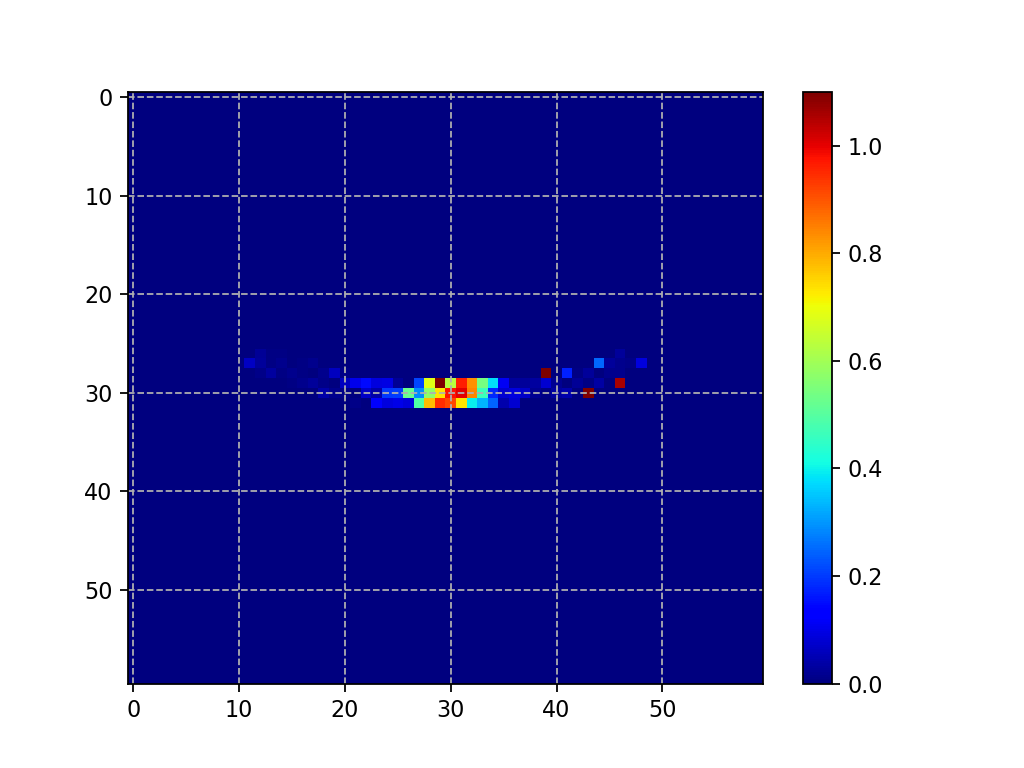

In [112]:
interp2d.shape = (bm_pix, bm_pix)
pylab.subplot(111)
pylab.imshow(interp2d.T, aspect='auto', cmap='jet', vmin=0, vmax=1.1)
pylab.grid(ls='dashed')
pylab.colorbar()

<IPython.core.display.Javascript object>


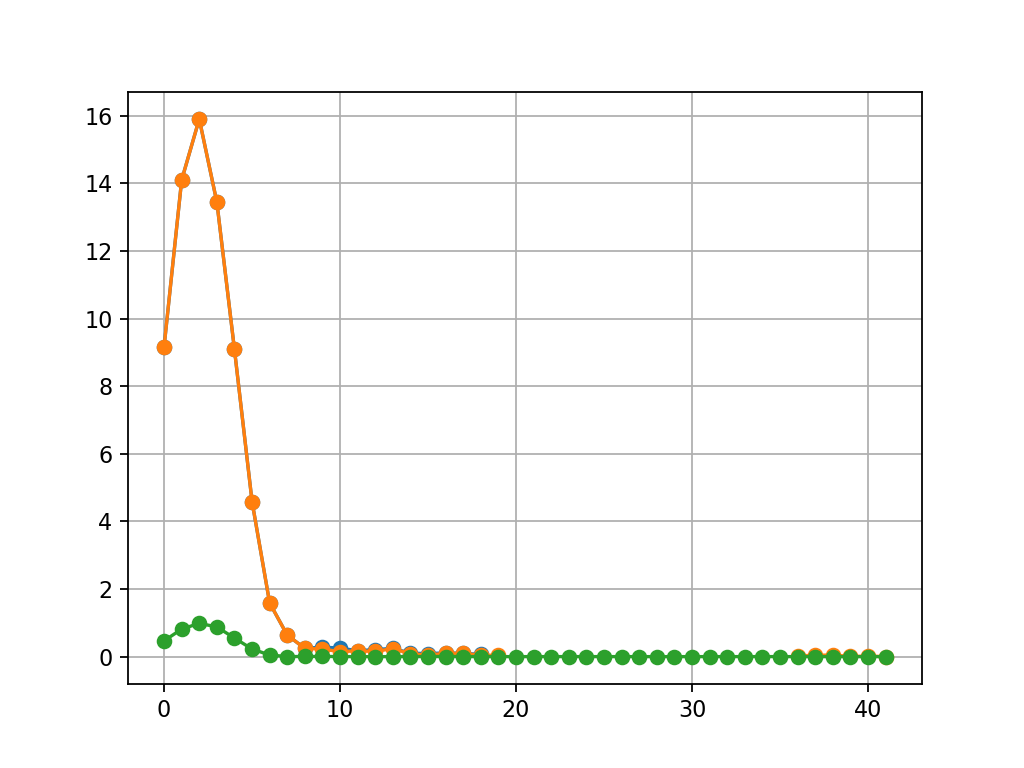

In [32]:
pylab.plot(catd.pflux_array[0,:], 'o-')
pylab.plot(peaks1[0,:], 'o-')

<IPython.core.display.Javascript object>


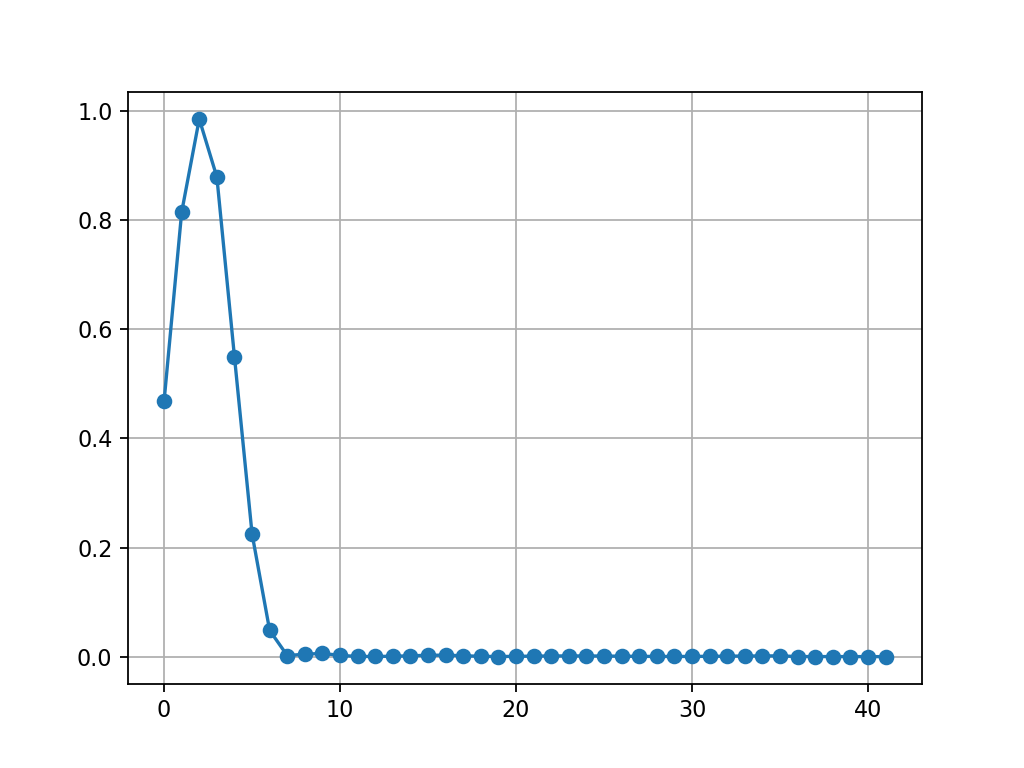

In [38]:
pylab.plot(catd.beam_array[0,:], 'o-')
pylab.grid()
#pylab.plot(beam1[0,:], 'o-')

<IPython.core.display.Javascript object>


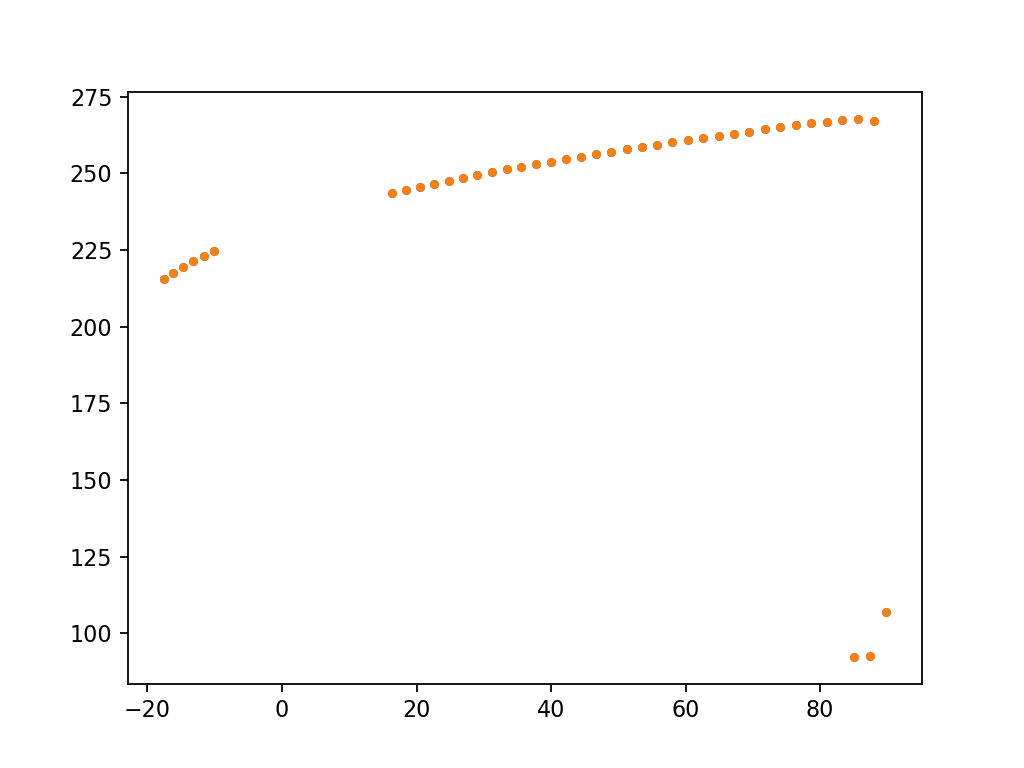

In [117]:
pylab.plot(alts[0,:],azs[0,:], '.')
pylab.plot(catd.azalt_array[0,0,:], catd.azalt_array[1, 0, :], '.')

In [118]:
beamdata = beam['data']
print beamdata.shape

(49152,)


In [133]:
bmvals = []
for i in range(42):
    beamval = healpy.get_interp_val(beam['data'], np.pi/2 - catd.azalt_array[1,0,i] * np.pi/180., catd.azalt_array[0,0,i] * np.pi/180.)
    print catd.azalt_array[1,0,i], catd.azalt_array[0,0,i], beamval
    bmvals.append(beamval)

92.38237248697861 85.11083698336715 0.8400692047592008
92.52544445952287 87.42324533819915 0.8214535851387775
106.86632137674592 89.72613923951734 0.004766327692042403
267.1789413107333 87.95035152701655 0.0009710216474592986
267.6627372700236 85.63805928540043 0.0010907492872835377
267.33283913311203 83.32584217586519 0.001009126587045367
266.8167773601825 81.01757291567021 0.0008762266885222519
266.2262938460566 78.70746633458849 0.0007154635810469935
265.59791644241545 76.39900582909675 0.0005466592872077078
264.9472999428367 74.09563381453668 0.0003912684521774873
264.27958064957625 71.7915309697354 0.0002583835577123694
263.5991845252163 69.49016703079131 0.0001533709156529482
262.9088982869381 67.19499124323525 8.057230142805183e-05
262.20776570825797 64.90023209721855 3.6392629726648167e-05
261.4971528270098 62.60937298921793 1.563880129310831e-05
260.7780431904342 60.32587682514259 1.0057307270325304e-05
260.0483331002667 58.04404722722473 1.1521089706922145e-05
259.30865093391

In [129]:
bmvals = []
for i in range(42):
    beamval = healpy.get_interp_val(beam['data'], np.pi/2 - alts[0,i] * np.pi/180., azs[0,i] * np.pi/180.)
    print alts[0,i], azs[0,i], beamval
    bmvals.append(beamval)

85.11083698336715 92.38237248697861 0.468061663594764
87.42324533819915 92.52544445952287 0.8147791824133777
89.72613923951734 106.86632137674592 0.9854244576846602
87.95035152701655 267.1789413107333 0.8791780601612464
85.63805928540043 267.6627372700236 0.5497583928588556
83.32584217586519 267.33283913311203 0.2253017423598599
81.01757291567021 266.8167773601825 0.04833138738443119
78.70746633458849 266.2262938460566 0.002210018272540886
76.39900582909675 265.59791644241545 0.004644474637201882
74.09563381453667 264.9472999428367 0.006123530484048294
71.7915309697354 264.27958064957625 0.0024999077716645903
69.49016703079131 263.5991845252163 0.0005348510685823495
67.19499124323524 262.9088982869381 0.0005275253230870273
64.90023209721855 262.20776570825797 0.0008791042966837999
62.60937298921793 261.4971528270098 0.001712375473278882
60.325876825142586 260.7780431904342 0.0027431479358726147
58.04404722722473 260.0483331002667 0.002860178721526016
55.767384667413985 259.308650933911

<IPython.core.display.Javascript object>


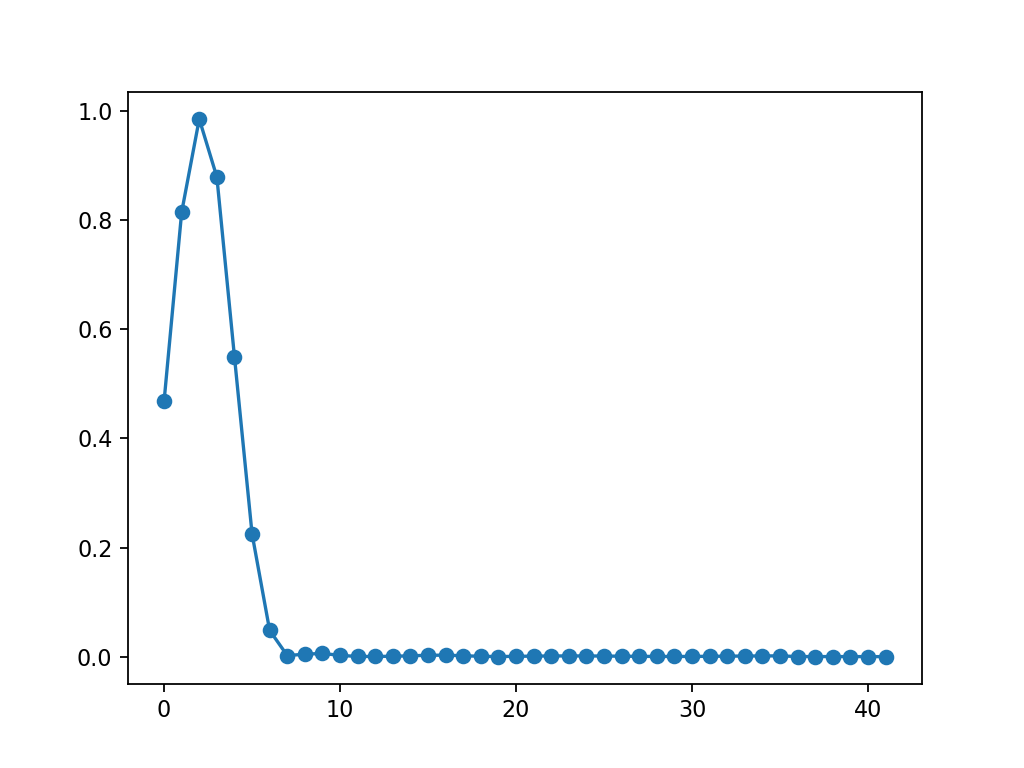

In [127]:
pylab.plot(bmvals, 'o-')